In [111]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os

## Pre-Defined Values

In [112]:
@torch.no_grad()
def linear_betas(timesteps, start = 0.0001, end = 0.02):
    return torch.linspace(start, end, timesteps)

In [113]:
@torch.no_grad()
def get_val(vals, t, x_shape, device = "cpu"):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(device) # one value for each image in the batch
    return out

In [114]:
@torch.no_grad()
def forward_diffusion(x_0, t, device = "cpu"):
    noise = torch.rand_like(x_0)
    sqrt_cumulative_alphas_t = get_val(sqrt_cumulative_alphas, t, x_0.shape)
    sqrt_one_minus_cumulative_alphas_t = get_val(sqrt_one_minus_cumulative_alphas, t, x_0.shape)
    out = sqrt_cumulative_alphas_t.to(device) * x_0.to(device) + sqrt_one_minus_cumulative_alphas_t.to(device) * noise.to(device)
    return out, noise.to(device)

In [115]:
T = 300
betas = linear_betas(timesteps = T)
print("betas: ", betas.shape)
alphas = 1.0 - betas
print("alphas: ", alphas.shape)
cumulative_alphas = torch.cumprod(alphas, axis = 0)
print("cumulative_alphas: ", cumulative_alphas.shape)
cumulative_alphas_prev = F.pad(cumulative_alphas[:-1], (1,0), value = 1.0)
print("cumulative_alphas_prev: ", cumulative_alphas_prev.shape)
sqrt_rec_alphas = torch.sqrt(1.0 / alphas)
print("sqrt_rec_alphas: ", sqrt_rec_alphas.shape)
sqrt_cumulative_alphas = torch.sqrt(cumulative_alphas)
print("sqrt_cumulative_alphas: ", sqrt_cumulative_alphas.shape)
sqrt_one_minus_cumulative_alphas = torch.sqrt(1.0 - cumulative_alphas)
print("sqrt_one_minus_cumulative_alphas: ", sqrt_one_minus_cumulative_alphas.shape)
posterior_variance = betas * (1.0 - cumulative_alphas_prev) / (1.0 - cumulative_alphas)
print("posterior_variance: ", posterior_variance.shape)

betas:  torch.Size([300])
alphas:  torch.Size([300])
cumulative_alphas:  torch.Size([300])
cumulative_alphas_prev:  torch.Size([300])
sqrt_rec_alphas:  torch.Size([300])
sqrt_cumulative_alphas:  torch.Size([300])
sqrt_one_minus_cumulative_alphas:  torch.Size([300])
posterior_variance:  torch.Size([300])


In [116]:
image_size = (3, 64, 64)
batch_size = 64
image_batch = torch.randn(batch_size, *(image_size)).to("cuda")
t = torch.randint(0, T, (image_batch.shape[0],)).long()
print(t.shape)
print(image_batch.shape)
val = get_val(sqrt_cumulative_alphas, t, image_batch.shape)
print(val.shape)
val, noise = forward_diffusion(image_batch, t, image_batch.device)
print(val.device, noise.device)

torch.Size([64])
torch.Size([64, 3, 64, 64])
torch.Size([64, 1, 1, 1])
cuda:0 cuda:0


## Dataset

In [117]:
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

In [118]:
class PokemonDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for folder_name in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder_name)
            if os.path.isdir(folder_path):
                for file_name in os.listdir(folder_path):
                    if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        file_path = os.path.join(folder_path, file_name)
                        self.image_paths.append(file_path)
                        self.labels.append(folder_name.lower())
        self.label_to_index = {label:idx for idx,label in enumerate(set(self.labels))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        label_idx = self.label_to_index[label]
        if self.transform:
            image = self.transform(image)
        return image, label_idx, label

    def get_label_index(self, label):
        return self.label_to_index.get(label, None)

In [119]:
root_dir = "pokemon/"
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(lambda t:(t * 2) - 1)
])

dataset = PokemonDataset(root_dir, transform = transform)

In [120]:
dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)
img, idx, label = next(iter(dataloader))
print(img.shape)

torch.Size([64, 3, 128, 128])


## Model

In [121]:
from torch import nn
import math
from torch import optim
from tqdm import tqdm
import numpy as np

In [122]:
@torch.no_grad()
def sample_timestep(x, t, label,model_output):
    betas_t = get_val(betas, t, x.shape, x.device)
    sqrt_one_minus_cumulative_alphas_t = get_val(
        sqrt_one_minus_cumulative_alphas, t, x.shape, x.device
    )
    sqrt_rec_alphas_t = get_val(sqrt_rec_alphas, t, x.shape, x.device)
    model_mean = sqrt_rec_alphas_t * (
        x - betas_t * model_output / sqrt_one_minus_cumulative_alphas_t
    )
    posterior_variance_t = get_val(posterior_variance, t, x.shape, x.device)
    noise = torch.randn_like(x)
    model_mean = model_mean + torch.sqrt(posterior_variance_t) * noise
    return torch.clamp(model_mean, -1.0, 1.0)

In [123]:
class Encoder(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=4, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        out = self.relu(self.bnorm1(self.conv1(x)))
        out = self.relu(self.bnorm2(self.conv2(out)))
        return out

In [124]:
class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super(UpBlock, self).__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(in_channels= 2*in_ch, out_channels=out_ch, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=3,padding=1)
        self.transpose_conv1 = nn.ConvTranspose2d(in_channels=out_ch, out_channels=out_ch, kernel_size=4, stride=2, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        out = self.relu(self.bnorm1(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb.unsqueeze(-1).unsqueeze(-1)
        out = out + time_emb
        out = self.relu(self.bnorm2(self.conv2(out)))
        out = self.transpose_conv1(out)
        return out

In [125]:
class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super(DownBlock, self).__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(in_channels= in_ch, out_channels=out_ch, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=3,padding=1)
        self.pool1 = nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=4, stride=2, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        out = self.relu(self.bnorm1(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb.unsqueeze(-1).unsqueeze(-1)
        out = out + time_emb
        out = self.relu(self.bnorm2(self.conv2(out)))
        out = self.pool1(out)
        return out

In [126]:
class SelfAttention(nn.Module):
    def __init__(self, channels, image_size, head = 4):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.image_size = image_size
        self.mha = nn.MultiheadAttention(channels, head, batch_first = True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels)
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.image_size * self.image_size).swapaxes(1,2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        attention_value = attention_value.swapaxes(2,1).view(-1, self.channels, self.image_size, self.image_size)
        return attention_value

In [127]:
class PositionEmbedding(nn.Module):
    def __init__(self,dim):
        super(PositionEmbedding, self).__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device = device) * -embeddings)
        embeddings = time.unsqueeze(-1) * embeddings.unsqueeze(0)
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim = -1)
        return embeddings

In [128]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        down_channels = (64, 128, 256, 512)
        up_channels = (512, 256, 128, 64)
        down_size = (32, 16, 8, 4)
        up_size = (4, 8, 16, 32)
        time_emb_dim = 32
        num_classes = 721

        self.time_mlp = nn.Sequential(
            PositionEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        self.cls_mlp = nn.Embedding(num_classes, time_emb_dim)

        self.downs = nn.ModuleList([
            nn.Sequential(
                DownBlock(down_channels[i], down_channels[i+1], time_emb_dim),
                SelfAttention(down_channels[i+1], down_size[i+1])
            )
             for i in range(len(down_channels) - 1)   
        ])
        self.ups = nn.ModuleList([
            nn.Sequential(
                UpBlock(up_channels[i], up_channels[i+1], time_emb_dim),
                SelfAttention(up_channels[i+1], up_size[i+1])
            )
            for i in range(len(up_channels) - 1)
        ])
        self.output = nn.Conv2d(in_channels=up_channels[-1], out_channels=up_channels[-1], kernel_size= 3, padding=1)

    def forward(self, x, timestep, label = None):
        t = self.time_mlp(timestep)
        if label is not None:
            t = t + self.cls_mlp(label)

        residual_inputs = []
        for down in self.downs:
            x = down[0](x, t)
            x = down[1](x)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim = 1)
            x = up[0](x, t)
            x = up[1](x)
        x = self.output(x)
        return x

In [129]:
class Decoder(nn.Module):
    def __init__(self, in_ch, out_ch, image_out):
        super(Decoder, self).__init__()
        self.transpose_conv1 = nn.ConvTranspose2d(in_channels=in_ch, out_channels=out_ch, kernel_size=4, stride=2, padding=1)
        self.transpose_conv2 = nn.ConvTranspose2d(in_channels=out_ch, out_channels= out_ch, kernel_size=4, stride=2, padding=1)
        self.output = nn.Conv2d(in_channels=out_ch, out_channels= image_out, kernel_size=1)
        self.relu = nn.ReLU()
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        out = self.relu(self.bnorm1(self.transpose_conv1(x)))
        out = self.relu(self.bnorm2(self.transpose_conv2(out)))
        out = self.output(out)
        return out

In [130]:
class LatentDiffusionModel(nn.Module):
    def __init__(self):
        super(LatentDiffusionModel, self).__init__()
        self.encoder = Encoder(3, 64)
        self.reverse_diffusion = UNet()
        self.decoder = Decoder(64, 32, 3)

    def forward(self, x, timestep, label = None, train = True):
        if train:
            x = self.encoder(x)
            x_noisy, noise = forward_diffusion(x, timestep, x.device)
            noise_predicted = self.reverse_diffusion(x_noisy, timestep, label)
            x = sample_timestep(x_noisy, timestep, label, noise_predicted)
            x = torch.clamp(x, -1.0, 1.0)
        else:
            for i in range(0, timestep)[::-1]:
                t = torch.full((1, ), i, device = device, dtype = torch.long)
                noise_predicted = self.reverse_diffusion(x, timestep, label)
                x = sample_timestep(x, t, label, noise_predicted)
                x = torch.clamp(x, -1.0, 1.0)
            noise = noise_predicted = 0
                
        predicted_x = self.decoder(x)
        return predicted_x, noise, noise_predicted

In [132]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LatentDiffusionModel().to(device)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  18224035


LatentDiffusionModel(
  (encoder): Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (relu): ReLU()
    (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (reverse_diffusion): UNet(
    (time_mlp): Sequential(
      (0): PositionEmbedding()
      (1): Linear(in_features=32, out_features=32, bias=True)
      (2): ReLU()
    )
    (cls_mlp): Embedding(721, 32)
    (downs): ModuleList(
      (0): Sequential(
        (0): DownBlock(
          (time_mlp): Linear(in_features=32, out_features=128, bias=True)
          (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (pool1): Conv2d(128, 128, kernel_size=(4, 4), strid

## Training

In [133]:
criterion = nn.MSELoss()
optimizer = optimizer = optim.AdamW(model.parameters(), lr = 1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


In [134]:
def get_loss(model, x, t, labels, loss):
    t_hat = torch.clamp(t - 1, min=0)
    x_noisy, _ = forward_diffusion(x, t_hat ,x.device)
    predicted_x, noise, predicted_noise = model(x, t, labels)
    diffusion_loss = loss(noise, predicted_noise)
    reconstruction_loss = loss(x_noisy, predicted_x)
    total_loss = 1.0 * diffusion_loss + 1.0 * reconstruction_loss
    return total_loss

In [1]:
epochs = 100
for epoch in range(epochs):
    epoch_loss = 0
    for image, labels, _ in tqdm(dataloader ,desc = f"Epoch {epoch + 1} / {epochs}"):
        optimizer.zero_grad()
        labels = labels.to(device)
        image = image.to(device)
        t = torch.randint(1, T, (image.shape[0],), device = device).long()
        if np.random.random() < 0.1:
            labels = None
        loss = get_loss(model, image, t, labels, criterion)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
    # scheduler.step()
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f'Epoch : {epoch + 1}, loss: {epoch_loss /len(dataloader)}')

In [136]:
def show_tensor_image(image):
    reverse_transform = transforms.Compose([
        transforms.Lambda(lambda t : (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1,2,0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage()
    ])

    if len(image.shape) == 4:
        image = image[0, :,:,:]
    return reverse_transform(image)

In [137]:
@torch.no_grad()
def sample_plot_image(label):
    img_size = 32
    img = torch.randn((1, 64, img_size, img_size), device = device)
    label = dataset.get_label_index(label)
    t = torch.full((1, ), T, device = device, dtype = torch.long)
    if label is not None:
        label = torch.tensor([label]).to('cuda')
    predicted_x, _, _ = model(img, t, label, train = False)
    img = torch.clamp(predicted_x, -1.0, 1.0)
    print(img.shape)
    plt.figure(figsize = (3,4))
    plt.axis('off')
    # show_tensor_image(image)
    plt.imshow(show_tensor_image(img.detach().cpu()))

torch.Size([1, 3, 128, 128])


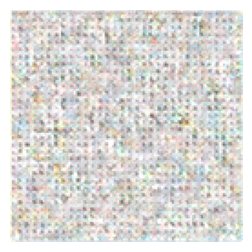

In [139]:
x = sample_plot_image('meganium')